In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda
import torchinfo
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import math
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU Device:【{}:{}】".format(device.type, device.index))
    torch.cuda.set_device(0)

GPU Device:【cuda:None】


In [3]:
class CustomDataset(Dataset):
    def __init__(self, data:np.ndarray, labels:np.ndarray, transform=ToTensor(), 
    target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))):
        self.data:torch.Tensor = torch.from_numpy(data)
        self.labels:torch.Tensor = torch.from_numpy(labels)
        self.transform = None
        self.target_transform = None
        # self.transform = transform
        # self.target_transform = target_transform
        # self.shuffle()
    
    def shuffle(self, seed=None):
        '\n        seed(self, seed=None)\n\n        Reseed a legacy MT19937 BitGenerator\n        '
        self.shuffle_seed = np.random.randint(1, 65535) if seed is None else seed
        print(f"随机种子：{self.shuffle_seed}")
        np.random.seed(self.shuffle_seed)
        np.random.shuffle(self.data)
        np.random.seed(self.shuffle_seed)
        np.random.shuffle(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx, 0]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

In [4]:
def load_dataset(path="dataset.npz", train_percent=0.8) -> tuple:
    with np.load(path) as dataset:
        full_data = dataset["data"].astype(np.float32)
        full_labels = dataset["labels"].astype(np.int64)
    train_size = int(full_data.shape[0]*train_percent)
    test_size = full_data.shape[0]-train_size
    seed = np.random.randint(1, 65535) # 35468
    np.random.seed(seed)
    np.random.shuffle(full_data)
    np.random.seed(seed)
    np.random.shuffle(full_labels)
    train_data, test_data = full_data[:train_size], full_data[train_size:]
    train_labels, test_labels = full_labels[:train_size], full_labels[train_size:]
    print(f"训练集大小：{train_size}", f"测试集大小：{test_size}", f"随机种子：{seed}")
    train_dataset = CustomDataset(train_data, train_labels)
    test_dataset = CustomDataset(test_data, test_labels)
    return train_dataset, test_dataset

In [5]:
train_dataset, test_dataset = load_dataset("D:\\datasets\\ABIDE\\ABIDE_augmented_dataset.npz", 0.8)

训练集大小：9636 测试集大小：2409 随机种子：62727


In [6]:
batch_size=64

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    data_shape = X.shape
    label_shape = y.shape
    print(f"Shape of X [N, L, H]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, L, H]: torch.Size([64, 60, 116])
Shape of y: torch.Size([64]) torch.int64


In [7]:
class DWConv(nn.Module):
    def __init__(self, dim:int):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv1d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x):
        x = self.dwconv(x)
        return x

In [8]:
class LKA(nn.Module):
    def __init__(self, dim:int):
        super().__init__()
        self.conv0 = nn.Conv1d(dim, dim, 5, padding=2, groups=dim)
        self.conv_spatial = nn.Conv1d(dim, dim, 7, stride=1, padding=9, groups=dim, dilation=3)
        self.conv1 = nn.Conv1d(dim, dim, 1)

    def forward(self, x):
        u = x.clone()        
        attn = self.conv0(x)
        attn = self.conv_spatial(attn)
        attn = self.conv1(attn)

        return u * attn

In [9]:
class ResBlock(nn.Module):

    def __init__(self, out_channels:int=None, device=None, *args, **wargs):
        super().__init__(*args, **wargs)
        self.__built = False
        self.out_channels = out_channels
        self.device = device

    def build(self, input_shape):
        self.input_shape = input_shape
        in_channels = input_shape[1]
        out_channels = in_channels if self.out_channels is None else in_channels
        # resolve output shape in model summary
        self.conv = LKA(in_channels)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_channels)
        self.downconv = DWConv(in_channels)
        self.output_shape = input_shape
        self.__built = True
        self.to(self.device)

    def forward(self, x:np.ndarray):
        fx:np.ndarray = x
        fx = self.conv(fx)
        fx = self.bn(fx)
        if fx.shape[-1] != x.shape[-1]:
            x = self.downconv(x)
        return fx + x

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False

In [70]:
class LKAResNet(nn.Module):
    def __init__(self, device=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__built:bool = False
        self.device:torch.DeviceObjType = device
    
    def build(self, input_shape):
        self.lstm = nn.LSTM(116, 116, 2, batch_first=True)
        # An ordinary ResNet, but put blocks in a list. New blocks will be added into this list when training.
        # 常规的残差网络，但将残差块放在一个list中，训练时会将新块添加到这里
        self.blocks:nn.ModuleList = nn.ModuleList([ResBlock() for _ in range(3)])
        for block in self.blocks:
            block.build(input_shape)
            block.to(self.device)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(np.prod(input_shape[1:]), 2)
        self.__built = True

    def compile(self, dataloader:DataLoader, loss_fn, optimizer, lr=1e-2):
        self.batch_size:int = dataloader.batch_size
        for X, y in dataloader:
            self.input_shape:tuple = X.shape
            self.output_shape:tuple = y.shape
            break
        self.build(self.input_shape)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        self.to(self.device)
    
    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def fit(self, dataloader:DataLoader, epochs:int=1):
        size = len(dataloader.dataset)
        num_batches = size // self.batch_size
        time_collection = []
        loss_collection = []
        correct_collection = []
        self.train()
        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")
            loss, correct = 0, 0
            time_delta = 0
            for batch, (X, y) in enumerate(dataloader):
                X = X.to(device)
                y = y.to(device)

                # 计时
                torch.cuda.synchronize()
                time_start = time.time()

                # Compute prediction error
                pred = self.forward(X)
                batch_loss = self.loss_fn(pred, y)

                # Backpropagation
                batch_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # 计时结束
                torch.cuda.synchronize()
                time_end = time.time()

                current = batch * self.batch_size + len(X)

                batch_loss = batch_loss.item()
                loss += batch_loss

                batch_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                correct += batch_correct
                batch_correct /= len(X)

                time_delta += time_end - time_start
                print(f"\r{batch+1}/{num_batches+1}  [{current:>3d}/{size:>3d}] - batch loss: {batch_loss:>7f} - batch accuracy: {(100*batch_correct):>0.1f}% - {time_delta/(batch+1)*1000:>0.3f}ms/batch", end = "", flush=True)
            loss /= num_batches
            correct /= size
            print(f"\n-- Average loss: {loss:>7f} - Accuracy: {(100*correct):>0.1f}% - {time_delta*1000:>0.3f}ms")
            time_collection.append(time_delta)
            loss_collection.append(loss)
            correct_collection.append(correct)
        print("\n", torchinfo.summary(self, input_size=self.input_shape))
        return correct_collection, loss_collection, time_collection

    def test(self, dataloader:DataLoader, return_preds=False):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        if return_preds:
            ys = []
            preds = []
        self.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.forward(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                if return_preds:
                    ys = np.hstack((ys, y.cpu()))
                    preds = np.hstack((preds, pred.argmax(1).cpu()))
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return ys, preds

In [71]:
class VLKAResNet(nn.Module):
    def __init__(self, device=None, freeze_block=False, copy_block=False, cache=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__blocks_num:int = 1
        self.__frozen_blocks_num:int = 0
        self.__built:bool = False
        self.cache:bool = cache
        self.__cache:list(torch.TensorType) = []
        self.device:torch.DeviceObjType = device
        self.copy_block:bool = copy_block
        self.freeze_block = freeze_block
    
    def build(self, input_shape):
        self.lstm = nn.LSTM(116, 116, 2, batch_first=True)
        # An ordinary ResNet, but put blocks in a list. New blocks will be added into this list when training.
        # 常规的残差网络，但将残差块放在一个list中，训练时会将新块添加到这里
        self.blocks:nn.ModuleList = nn.ModuleList([ResBlock()])
        for block in self.blocks:
            block.build(input_shape)
            block.to(self.device)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(np.prod(input_shape[1:]), 2)
        self.__built = True

    def compile(self, dataloader:DataLoader, loss_fn, optimizer, lr=1e-2):
        self.batch_size:int = dataloader.batch_size
        for X, y in dataloader:
            self.input_shape:tuple = X.shape
            self.output_shape:tuple = y.shape
            break
        self.build(self.input_shape)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        self.to(self.device)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        if self.cache:
            for i in range(self.__frozen_blocks_num, self.__blocks_num):
                x = self.blocks[i](x)
        else:
            for i in range(self.__blocks_num):
                x = self.blocks[i](x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def getBlocksNum(self):
        return self.__blocks_num
    
    def freeze(self, block:ResBlock):
        for param in block.parameters():
            param.requires_grad = False
    
    def __forward_cache(self, block):
        if self.cache:
            for batch, X in enumerate(self.__cache):
                self.__cache[batch] = block(X.to(self.device))

    def addNewBlock(self, copy_last=False):
        print("----------")
        print(f"{'Copying' if copy_last else 'Adding'} new block...")
        newBlock = ResBlock()
        last_block:ResBlock = self.blocks[-1]
        newBlock.build(last_block.output_shape)
        if copy_last:
            # 复制上一层参数
            newBlock.load_state_dict(last_block.state_dict())
        self.blocks.append(newBlock)
        newBlock.to(self.device)
        self.__blocks_num += 1
        if self.freeze_block:
            self.freeze(last_block)
        self.__frozen_blocks_num += 1
        self.__forward_cache(last_block)
        print("Success!")
    
    def add_condition(self, epoch):
        if self.__blocks_num < 3:
            if epoch and epoch%5 == 0:
                return True
        return False

    def fit(self, dataloader:DataLoader, epochs:int=1):
        size = len(dataloader.dataset)
        num_batches = size // self.batch_size
        time_collection = []
        loss_collection = []
        correct_collection = []
        self.train()
        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")
            if self.add_condition(epoch):
                self.addNewBlock(self.copy_block)
            loss, correct = 0, 0
            time_delta = 0
            for batch, (X, y) in enumerate(dataloader):
                if self.cache:
                    if epoch == 0:
                        self.__cache.append(X)
                    X = self.__cache[batch].to(device)
                else:
                    X = X.to(device)
                y = y.to(device)

                # 计时
                torch.cuda.synchronize()
                time_start = time.time()

                # Compute prediction error
                pred = self.forward(X)
                batch_loss = self.loss_fn(pred, y)

                # Backpropagation
                batch_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # 计时结束
                torch.cuda.synchronize()
                time_end = time.time()

                current = batch * self.batch_size + len(X)

                batch_loss = batch_loss.item()
                loss += batch_loss

                batch_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                correct += batch_correct
                batch_correct /= len(X)

                time_delta += time_end - time_start
                print(f"\r{batch+1}/{num_batches+1}  [{current:>3d}/{size:>3d}] - batch loss: {batch_loss:>7f} - batch accuracy: {(100*batch_correct):>0.1f}% - {time_delta/(batch+1)*1000:>0.3f}ms/batch", end = "", flush=True)
            loss /= num_batches
            correct /= size
            print(f"\n-- Average loss: {loss:>7f} - Accuracy: {(100*correct):>0.1f}% - {time_delta*1000:>0.3f}ms")
            time_collection.append(time_delta)
            loss_collection.append(loss)
            correct_collection.append(correct)
        print("\n", torchinfo.summary(self, input_size=self.input_shape))
        return correct_collection, loss_collection, time_collection

    def test(self, dataloader:DataLoader, return_preds=False):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        if return_preds:
            ys = []
            preds = []
        self.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.forward(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                if return_preds:
                    ys = np.hstack((ys, y.cpu()))
                    preds = np.hstack((preds, pred.argmax(1).cpu()))
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return ys, preds


In [9]:
lr = 1e-4
epochs = 20
loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.Adam

In [13]:
correct, loss, timing = {}, {}, {}

In [14]:
base_model = LKAResNet(device)
base_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["RLKA"], loss["RLKA"], timing["RLKA"] = base_model.fit(train_dataloader, epochs=epochs)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.950668 - batch accuracy: 55.6% - 34.767ms/batch
-- Average loss: 0.812813 - Accuracy: 51.5% - 5249.827ms
Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.584583 - batch accuracy: 66.7% - 17.481ms/batch
-- Average loss: 0.626863 - Accuracy: 62.5% - 2639.635ms
Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.438115 - batch accuracy: 80.6% - 17.085ms/batch
-- Average loss: 0.541710 - Accuracy: 69.7% - 2579.768ms
Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.375439 - batch accuracy: 83.3% - 17.200ms/batch
-- Average loss: 0.478398 - Accuracy: 75.2% - 2597.214ms
Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.319948 - batch accuracy: 86.1% - 16.712ms/batch
-- Average loss: 0.425403 - Accuracy: 78.9% - 2523.460ms
Epoch: 6/20
151/151  [9636/9636] - batch loss: 0.275177 - batch accuracy: 88.9% - 16.522ms/batch
-- Average loss: 0.377809 - Accuracy: 81.6% - 2494.866ms
Epoch: 7/20
151/151  [9636/9636] - batch loss: 0.238672 - batch accuracy: 91

In [15]:
model = VLKAResNet(device, freeze_block=False, copy_block=False, cache=False)
model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["VRLKA"], loss["VRLKA"], timing["VRLKA"] = model.fit(train_dataloader, epochs=epochs)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.648130 - batch accuracy: 61.1% - 12.647ms/batch
-- Average loss: 0.717422 - Accuracy: 52.6% - 1909.709ms
Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.492905 - batch accuracy: 72.2% - 12.628ms/batch
-- Average loss: 0.624681 - Accuracy: 63.5% - 1906.876ms
Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.364229 - batch accuracy: 83.3% - 12.403ms/batch
-- Average loss: 0.542084 - Accuracy: 70.2% - 1872.780ms
Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.292184 - batch accuracy: 86.1% - 12.780ms/batch
-- Average loss: 0.455690 - Accuracy: 76.3% - 1929.792ms
Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.246036 - batch accuracy: 88.9% - 12.325ms/batch
-- Average loss: 0.373541 - Accuracy: 81.3% - 1861.020ms
Epoch: 6/20
----------
Adding new block...
Success!
151/151  [9636/9636] - batch loss: 0.223323 - batch accuracy: 88.9% - 13.675ms/batch
-- Average loss: 0.328774 - Accuracy: 83.2% - 2064.884ms
Epoch: 7/20
151/151  [9636/9636] - b

In [16]:
freeze_model = VLKAResNet(device, freeze_block=True, copy_block=False, cache=False)
freeze_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["freeze_parameters"], loss["freeze_parameters"], timing["freeze_parameters"] = freeze_model.fit(train_dataloader, epochs=epochs)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.645692 - batch accuracy: 61.1% - 12.405ms/batch
-- Average loss: 0.717891 - Accuracy: 51.4% - 1873.111ms
Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.523471 - batch accuracy: 72.2% - 12.417ms/batch
-- Average loss: 0.635958 - Accuracy: 61.7% - 1875.038ms
Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.419381 - batch accuracy: 83.3% - 12.200ms/batch
-- Average loss: 0.552418 - Accuracy: 69.7% - 1842.142ms
Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.322536 - batch accuracy: 88.9% - 12.539ms/batch
-- Average loss: 0.465307 - Accuracy: 75.9% - 1893.320ms
Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.286783 - batch accuracy: 86.1% - 12.292ms/batch
-- Average loss: 0.387956 - Accuracy: 80.7% - 1856.124ms
Epoch: 6/20
----------
Adding new block...
Success!
151/151  [9636/9636] - batch loss: 0.245953 - batch accuracy: 88.9% - 13.614ms/batch
-- Average loss: 0.352539 - Accuracy: 82.4% - 2055.787ms
Epoch: 7/20
151/151  [9636/9636] - b

In [17]:
copy_model = VLKAResNet(device, freeze_block=True, copy_block=True, cache=False)
copy_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["copy_parameters"], loss["copy_parameters"], timing["copy_parameters"] = copy_model.fit(train_dataloader, epochs=epochs)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.702270 - batch accuracy: 58.3% - 12.708ms/batch
-- Average loss: 0.720079 - Accuracy: 52.1% - 1918.867ms
Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.555380 - batch accuracy: 69.4% - 12.465ms/batch
-- Average loss: 0.637660 - Accuracy: 62.1% - 1882.220ms
Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.425764 - batch accuracy: 86.1% - 12.264ms/batch
-- Average loss: 0.556961 - Accuracy: 69.7% - 1851.852ms
Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.349359 - batch accuracy: 86.1% - 12.549ms/batch
-- Average loss: 0.471165 - Accuracy: 75.5% - 1894.867ms
Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.306014 - batch accuracy: 88.9% - 12.622ms/batch
-- Average loss: 0.389211 - Accuracy: 80.5% - 1905.927ms
Epoch: 6/20
----------
Copying new block...
Success!
151/151  [9636/9636] - batch loss: 0.260979 - batch accuracy: 88.9% - 13.432ms/batch
-- Average loss: 0.352608 - Accuracy: 81.6% - 2028.160ms
Epoch: 7/20
151/151  [9636/9636] - 

In [18]:
cache_model = VLKAResNet(device, freeze_block=True, copy_block=True, cache=True)
cache_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["use_cache"], loss["use_cache"], timing["use_cache"] = cache_model.fit(train_dataloader, epochs=epochs)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.664604 - batch accuracy: 55.6% - 12.450ms/batch
-- Average loss: 0.714092 - Accuracy: 52.7% - 1879.979ms
Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.563809 - batch accuracy: 63.9% - 12.321ms/batch
-- Average loss: 0.627430 - Accuracy: 62.8% - 1860.521ms
Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.439862 - batch accuracy: 75.0% - 12.427ms/batch
-- Average loss: 0.547360 - Accuracy: 70.3% - 1876.545ms
Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.336851 - batch accuracy: 86.1% - 12.574ms/batch
-- Average loss: 0.462628 - Accuracy: 75.9% - 1898.665ms
Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.243165 - batch accuracy: 88.9% - 12.305ms/batch
-- Average loss: 0.378917 - Accuracy: 81.2% - 1858.037ms
Epoch: 6/20
----------
Copying new block...
Success!
151/151  [9636/9636] - batch loss: 0.194289 - batch accuracy: 91.7% - 12.132ms/batch
-- Average loss: 0.310992 - Accuracy: 84.8% - 1831.883ms
Epoch: 7/20
151/151  [9636/9636] - 

In [ ]:
base_model.test(train_dataloader)
base_model.test(test_dataloader, True)

model.test(train_dataloader)
model.test(test_dataloader, True)

freeze_model.test(train_dataloader)
freeze_model.test(test_dataloader, True)

copy_model.test(train_dataloader)
copy_model.test(test_dataloader, True)

cache_model.test(train_dataloader)
cache_model.test(test_dataloader, True)

In [14]:
# 保存结果
import pickle
with open("LKA_res.pkl", "wb") as f:
    # pickle.dump(tmp, f)
    pickle.dump({
        "correct" : correct, 
        "loss"    : loss, 
        "timing"  : timing
    }, f)

In [9]:
# 加载结果
import pickle
with open("LKA_res.pkl", "rb") as f:
    tmp = pickle.load(f)
correct, loss, timing = tmp["correct"], tmp["loss"], tmp["timing"]
epochs = 20

In [6]:
import matplotlib.pyplot as plt
# import os

plt.rcParams['font.family']=['Times New Roman']
fontsize = 18
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.labelsize']=fontsize
bg_color = None
fig_format = "jpg"
fig_dir = "./figs/results"
# os.makedirs(fig_dir, exist_ok=True)

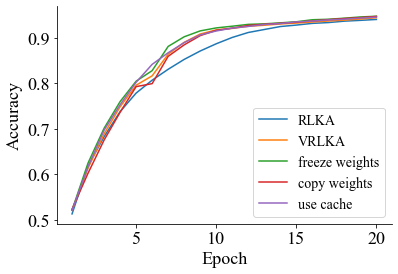

In [10]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in correct:
    ax.plot(x, correct[key], label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower right', prop = {'size':14}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Accuracy.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

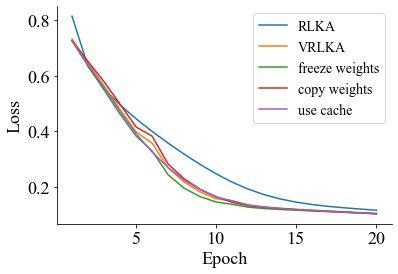

In [11]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in loss:
    ax.plot(x, loss[key], label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.legend(loc='upper right', prop = {'size':14}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Loss.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

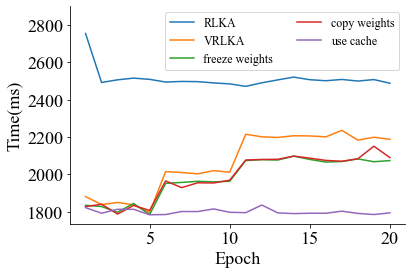

In [28]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in timing:
    y = [t*1000 for t in timing[key]]
    ax.plot(x, y, label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Time(ms)")
ax.set_ylim(top=2900)

ax.legend(loc='upper right', prop = {'size':12}, ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Time.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

In [ ]:
def test(self, dataloader:DataLoader, return_preds=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    if return_preds:
        ys = []
        preds = []
    self.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = self.forward(X)
            test_loss += self.loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if return_preds:
                ys = np.hstack((ys, y.cpu()))
                preds = np.hstack((preds, pred[...,1].cpu()))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return ys, preds

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.598389 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.204476 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.255799 

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.303845 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.214076 



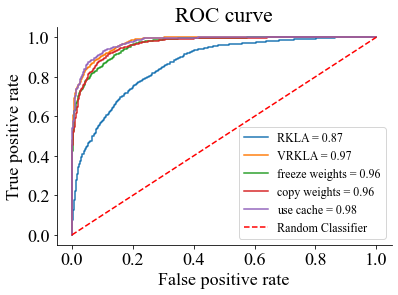

In [ ]:
fig, ax = plt.subplots()

ys, preds = test(base_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'RLKA = {auc_score:.2f}')

ys, preds = test(model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'VRLKA = {auc_score:.2f}')

ys, preds = test(freeze_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'freeze weights = {auc_score:.2f}')

ys, preds = test(copy_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'copy weights = {auc_score:.2f}')

ys, preds = test(cache_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'use cache = {auc_score:.2f}')

ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')  # 绘制随机分类器的ROC曲线
ax.set_xlabel('False positive rate')  # x轴标签为FPR
ax.set_ylabel('True positive rate')   # y轴标签为TPR
ax.set_title('ROC curve')             # 设置标题
ax.legend(loc='lower right', prop = {'size':12}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/ROC.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")